# Selection of more advanced FP topics  

In [ ]:
#require "fp"
open Base

## 1. Labelled & optional arguments

### 1.1 Labelled arguments

In OCaml, you can label the arguments to your functions, using `~`:

In [ ]:
let map x ~f =
  let rec iter accu still_to_be_processed =
    match still_to_be_processed with
    | [] -> List.rev accu
    | hd :: tl -> iter (f hd :: accu) tl
  in
  iter [] x

Labelled arguments allow you to swap the order in which arguments are passed to the function. Thus, instead of:

In [ ]:
[ 2; 3; 4 ] |> fun x -> map x ~f:(fun x -> x + 1)

you can write:

In [ ]:
[ 2; 3; 4 ] |> map ~f:(fun x -> x + 1)

You don't _have to_ use a function's labels, but OCaml will warn you if you omit them:

In [ ]:
map [ 2; 3; 4 ] (fun x -> x + 1)

Labelled arguments greatly facilitate the use of partial evaluation:

In [ ]:
let f ~a ~b c = a + b - c

In [ ]:
let g = f ~b:3

Without labelled arguments, we would need to do the following instead:

In [ ]:
let f a b c = a + b - c
let g = (fun a c -> f a 3 c)

### 1.2 Optional arguments

Consider the following function, where the first argument `a` is an `int option`:

In [ ]:
let maybe_add a x =
  match a with
  | Some y -> x + y
  | None -> x

OCaml lets you write this instead:

In [ ]:
let maybe_add ?a x =
  match a with
  | Some y -> x + y
  | None -> x

such that `a` is now officially an optional argument that can be omitted altogether: 

In [ ]:
maybe_add 3

If you want to specify the value of an optional parameter, use `~` with the appropriate label:

In [ ]:
maybe_add ~a:5 3

Optional arguments can also be given a default value, in which case they are no longer options inside the body of the function:

In [ ]:
let add_three_or_something_else ?(a = 3) x = a + x

In [ ]:
add_three_or_something_else 6

In [ ]:
add_three_or_something_else ~a:0 6

## 2. Dealing with errors

OCaml lets you define your own exceptions, which may carry some payload:

In [ ]:
exception Invalid_name of string

The example below will be based on a simplified version of the `president` type used in an earlier lecture:

In [ ]:
type simple_president = { name : string }

This is how an exception can be “raised”:

In [ ]:
let add_president ~list p =
  (* if name is invalid, raise an exception *)
  if String.length p.name < 2 then raise (Invalid_name p.name) else p :: list

In [ ]:
let us_pres = [ { name = "Biden" } ]

In [ ]:
let us_pres = add_president ~list:us_pres { name = "O" }

Notice how raising an exception immediately aborts your program. The point of exceptions is that they can be caught at runtime, to modify the flow of execution of your program:

In [ ]:
let add_many_presidents ~list x =
  List.fold x ~init:list ~f:(fun accu p ->
    try add_president ~list:accu p with
    | Invalid_name s ->
      Fp.Utils.print_msg Printf.(sprintf "Warning: %s invalid so not added!" s);
      accu)

In [ ]:
let us_pres = [ { name = "Biden" } ] in
add_many_presidents ~list:us_pres [ { name = "O" }; { name = "Obama" } ]

## 3. Software architecture in FP: the module system

OCaml has a brilliant module system that allows you to structure your codebase. Modules are essentially units that pack types and functions, and provide a namespace for those.
A distinction is made between module “implementations” (`struct ... end`) and module types or “signatures” (`sig ... end`):

In [ ]:
module type President_T = sig
  type t  = { last_name : string }

  exception Invalid_name of Base.string

  val of_name : string -> t
  val name : t -> string
  val add : list:t list -> t -> t list
end

A particular implementation of this signature would be, for example:

In [ ]:
module President : President_T
(* type-annotating here to show you the type of this module *) = struct
  type t = { last_name : string }

  exception Invalid_name of string

  let valid_name n = String.length n > 1
  let name p = p.last_name
  let of_name n = if valid_name n then { last_name = n } else raise (Invalid_name n)
  let add ~list p = p :: list
end

Types and values inside a module can be accessed using the `Module_name.something` notation. For example:

In [ ]:
let obama = President.of_name "Obama"

Module signatures allow you to restrict the things you want to expose to the user of your library. For example, we might want to “hide” the concrete definition of the `t` record type, to prevent the user from by-passing the function `of_name` and thus creating invalid presidents. Indeed, the way `P` is defined above, the user could do this:

In [ ]:
let invalid = President.{ last_name = "_" }

To prevent this, we can make `President.t` an abstract type:

In [ ]:
module type President_safe_T = sig
  type t
  (* notice that we have removed the record type definition !
     this makes t a so-called abstract type *)

  exception Invalid_name of Base.string

  val of_name : string -> t
  val name : t -> string
  val add : list:t list -> t -> t list
end

We can now restrict our `President` module to this type:

In [ ]:
module President_safe : President_safe_T = President

In [ ]:
let o = President_safe.{ last_name = ""}

The above fails, because `President_safe_T` does not expose the concrete implementation of the record type. So the user has only ONE option for creating values of type `President_safe.t`, and that is to use the function `of_name` provided by this module, in which the validity of the name is checked automatically:

In [ ]:
let o = President_safe.of_name "_"

This ensures that nobody can create invalid presidents.

## 4. Memoization & dynamic programming

In [ ]:
let rec fib = function
  | 0 -> 0
  | 1 -> 1
  | a ->
    if a < 0
    then raise (Invalid_argument "must be positive")
    else fib (a - 1) + fib (a - 2)

In [ ]:
List.init 8 ~f:fib

In [ ]:
let timeit f x =
  let t0 = Unix.gettimeofday () in
  let result = f x in
  let t1 = Unix.gettimeofday () in
  result, t1 -. t0 

In [ ]:
let times = List.init 36 ~f:(timeit fib) |> List.map ~f:snd

This scales horrendously (i.e. exponentially):

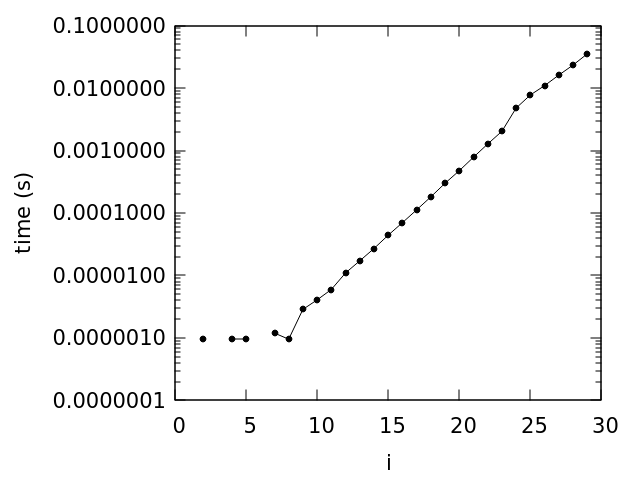

In the following, we will show that there is a general strategy for speeding up functions that otherwise perform a lot of redundant calculations. This strategy relies on caching (i.e. memorizing for later re-use) function evaluations, using so-called hash tables. Let's begin by learning how to use hash tables in OCaml.

### Hashtables in OCaml

In [ ]:
(* using Stdlib because Base might have shadowed the Stdlib.Hashtbl module... *)
let h = Stdlib.Hashtbl.create 1000

At this point, `h` is polymorphic. But its type will be fully determined upon first use: if we use it to store a `string` value using an `int` key, OCaml will immediately know that `h` has type `(int * string) Hashtbl.t`.

In [ ]:
Stdlib.Hashtbl.add h 0 "cambridge"

In [ ]:
Stdlib.Hashtbl.find h 0

OCaml raises a `Not_found` exception if we look up a key that has never been used:

In [ ]:
Stdlib.Hashtbl.find h 18

### Generic memoization function:

Now let's write our generic memoization function:

```ocaml
val memoize: ('a -> 'b) -> 'a -> 'b
```

In [ ]:
let memoize ?(size = 1000) f =
  let h = Stdlib.Hashtbl.create size in
  fun x ->
    try Stdlib.Hashtbl.find h x with
    | Stdlib.Not_found ->
      let y = f x in
      Stdlib.Hashtbl.add h x y;
      y

In [ ]:
let fib_mem = memoize fib

Now try evaluting the following line multiple times. You will see that the first one is slow, and every subsequent call is lightning fast:

In [ ]:
timeit fib_mem 37 |> snd

The problem, however, is that even though we have now memoized `fib 37`, our recursive function `fib` is UNABLE to make use of this to evaluate `fib 38` in a faster way.

To memoize recursive functions properly, we make use of the following trick:
- rewrite our recursive function by adding an extra parameter `f`, which is a function assumed to already know how to perform the “tail call”. So, if your original function was
```ocaml
let rec f x = (* [... some expression containing
                      a tail call (f z) ... ] *)  
```
you rewrite it this way:
```ocaml
let f_norec f_tail x = (* [ ... the same expression where you use
                      f_tail z instead of f z  ... ] *)
```
- write a generic `memoize_rec` function (see below)
- construct `memoize_rec f_norec` : this is a fully memoized version of your original recursive `f` function!

In [ ]:
let fib_norec fib_tail = function
  | 0 -> 0
  | 1 -> 1
  | a ->
    if a < 0
    then raise (Invalid_argument "must be positive")
    else fib_tail (a - 1) + fib_tail (a - 2)

In [ ]:
let memoize_rec f_norec =
  (* create a pointer to a generic 'a -> 'b function *)
  let fref = ref (fun _ -> raise Stdlib.Not_found) in
  (* memoize the f_norec function *)
  let f = memoize (fun x -> f_norec !fref x) in
  (* put the memoized function inside the box *)
  fref := f;
  (* return f *)
  f

In [ ]:
let fib = memoize_rec fib_norec

This new `fib` function is now able to cache every single call it makes to itself! In particular, observe the following:

In [ ]:
timeit fib 100 |> snd

In [ ]:
timeit fib 99 |> snd

Not only was the evaluation of `fib 100` much faster than before, but now you can tell that `fib 99` has been cached as part of evaluating `fib 100`, and is therefore even faster.

## 5. Laziness

(if time permits)